### Градиентный бустинг. Часть 1

#### План семинара:

1. [Задачи по теории](#tasks)
2. [Градиентный бустинг в sklearn](#sklearn)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pylab as plt
%pylab inline
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from time import time
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


#### Градиентный бустинг в sklearn  <a name="sklearn"></a>


Сегодня поработаем с датасетом `Customer Personality Analysis` с платформы Kaggle. Подробнее про данные можно прочитать [тут](https://www.kaggle.com/imakash3011/customer-personality-analysis).

Набор данных содрежит доступную информацию по клиентам и их покупательскому поведению. Сбор таких данных помогает бизнесу лучше понимать своих клиентов и облегчает им изменение продуктов в соответствии с конкретными потребностями, поведением и проблемами разных типов клиентов.

Доступны следующие признаки:

```
Socio-demographic features

ID: Customer's unique identifier
Year_Birth: Customer's birth year
Education: Customer's education level
Marital_Status: Customer's marital status
Income: Customer's yearly household income
Kidhome: Number of children in customer's household
Teenhome: Number of teenagers in customer's household
Dt_Customer: Date of customer's enrollment with the company
Recency: Number of days since customer's last purchase
Complain: 1 if customer complained in the last 2 years, 0 otherwise

Products

MntWines: Amount spent on wine in last 2 years
MntFruits: Amount spent on fruits in last 2 years
MntMeatProducts: Amount spent on meat in last 2 years
MntFishProducts: Amount spent on fish in last 2 years
MntSweetProducts: Amount spent on sweets in last 2 years
MntGoldProds: Amount spent on gold in last 2 years

Promotion

NumDealsPurchases: Number of purchases made with a discount
AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise

Place

NumWebPurchases: Number of purchases made through the company’s web site
NumCatalogPurchases: Number of purchases made using a catalogue
NumStorePurchases: Number of purchases made directly in stores
NumWebVisitsMonth: Number of visits to company’s web site in the last month

```

На основе социально-демографических признаков и интересных статистик по истории покупок продуктов и участию в предыдущих маркетинговых акциях попробуем для каждого клиента предсказать, участвовал ли он в последней маркетинговой акции или нет:

`Response: 1 if customer accepted the offer in the last campaign, 0 otherwise`

Эта задача часто используется в маркетинге, чтобы заранее предсказывать, насколько новая промоакция будет успешной для выбранного сегмента пользователей.

Посмотрим на датасет:

In [ ]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


На этом шаге нужно отдельно провести EDA: посмотреть, сколько у нас наблюдений и признаков, какого типа данных каждый признак; проверить наличие пропусков, выбросов и обработать их; сделать препроцессинг признаков - например, закодировать и нормализовать их; можно сгенерировать новые признаки на основе исходных и сделать обзор признаков и другое.

Все эти шаги очень важны, но т.к. в этот раз хотим сфокусируемся на модели градиентного бустинга, отберем только пару признаков из датасета, обработаем пропущенные значения, и перейдем к обучению моделей для их сравнения.

In [ ]:
X = df[['Year_Birth', 'Income', 'Kidhome', 'Recency', 'MntWines',
        'MntSweetProducts', 'NumWebPurchases', 'NumStorePurchases',
        'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4',
        'AcceptedCmp5']]
y = df['Response']
y.value_counts(normalize=True)

0    0.850893
1    0.149107
Name: Response, dtype: float64

In [ ]:
X.isna().sum()

Year_Birth            0
Income               24
Kidhome               0
Recency               0
MntWines              0
MntSweetProducts      0
NumWebPurchases       0
NumStorePurchases     0
AcceptedCmp1          0
AcceptedCmp2          0
AcceptedCmp3          0
AcceptedCmp4          0
AcceptedCmp5          0
dtype: int64

In [ ]:
for col in tqdm(X.columns):
    X[col] = X[col].fillna(np.mean(X[col]))

100%|██████████| 13/13 [00:00<00:00, 928.64it/s]


Воспользуемся имплементацией градиентного бустинга из sklearn. Обратите внимание, доступны отдельно модели для классификации и регрессии - `GradientBoostingClassifier` и `GradientBoostingRegressor`.

Посмотрим на часть наиболее важных параметров для инициализации модели градиентного бустинга (для классификации). Как можно заметить, очень похоже на случайный лес:

```
loss='deviance' - функция потерь,
learning_rate=0.1 - скорость обучения,
n_estimators=100 - количество деревьев,
subsample=1.0 - доля наблюдений для обучения каждого базового алгоритма,
criterion='friedman_mse' - информационный критерий,
min_samples_split=2 - минимальное количество наблюдений, чтобы продолжать разбиение выборки в текущем узле,
min_samples_leaf=1 - минимальное количество наблюдений в листе,
max_depth=3 - максимальная глубина каждого базового алгоритма,
min_impurity_decrease=0.0 - сплит узла будет сделан, только если удалось достигнуть большего или равного увеличения значения по метрике степени упорядоченности выборки (impurity)
по формуле N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)
min_impurity_split=None - то же самое, только задаем само значение метрики,
max_features=None - максимальное количество признаков, используемое для сплита,
verbose=0 - показывать ли в выводе ячейки каждую итерацию обучения
```

Для разминки, построим градиентный бустинг с 10 деревьями. Поменяем только критерий и выведем значения функции ошибки для каждой итерации, остальные параметры оставим дефолтными. Обратите внимание, что в задаче классификации композиция базовых алгоритмов будет выдавать вещественные числа, которые по смыслу являются оценками логита - логарифм отношения вероятности положительного класса к вероятности отрицательного класса, поэтому используем `mse`.

In [ ]:
model = GradientBoostingClassifier(
    criterion='friedman_mse',
    n_estimators=10,
    random_state=42,
    verbose=1
)

round(cross_val_score(model, X, y, cv=3, scoring='f1').mean(), 2)

      Iter       Train Loss   Remaining Time 
         1           0.7974            0.07s
         2           0.7699            0.13s
         3           0.7482            0.12s
         4           0.7311            0.08s
         5           0.7152            0.08s
         6           0.7023            0.05s
         7           0.6897            0.04s
         8           0.6794            0.03s
         9           0.6699            0.01s
        10           0.6603            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7951            0.05s
         2           0.7641            0.04s
         3           0.7408            0.04s
         4           0.7207            0.04s
         5           0.7056            0.03s
         6           0.6889            0.02s
         7           0.6750            0.02s
         8           0.6634            0.01s
         9           0.6522            0.01s
        10           0.6424            0.00s
      It

0.25

Сравним, как ведут себя градиентный бустинг и случайный лес (частный случай бэггинга) с ростом числа базовых алгоритмов.

В **случайном лесе** все деревья настраиваются на различные выборки из одного и того же распределения. При этом, некоторые из них могут переобучиться, но усреднение позволяет это ослабить (для некоррелированных алгоритмов диперсия композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов). Если $N$ достаточно велико, то последующие увеличение числа `n_estimators` не позволят улучшить качество модели.

В **градиентном бустинге** при достаточно большом $N$ появляется риск переобучения, так как увеличение числа базовых алгоритмов `n_estimators` будет продолжать настраиваться на обучающую выборку, уменьшая ошибку на ней, в то же время уменьшая обобщающую способность итоговой модели.

Нарисуем графики качества в зависимости от числа деревьев для случайного леса на тренировочной и тестовой выборках. Также, нарисуем график времени обучения алгоритма от числа деревьев.

In [ ]:
from time import time

def get_model_scores(selected_model, n_list=np.arange(10, 250, 20), learning_rate=0.1):

    acc_train = []
    acc_test = []
    time_list = []

    n_list = n_list

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

    for n in tqdm(n_list):
        model = selected_model(n_estimators=n, random_state=42)
        # у RF нет параметра learning_rate
        if type(model) == type(GradientBoostingClassifier()):
            model.learning_rate = learning_rate
        t_start = time()
        model.fit(X_train, y_train)
        t_end = time()
        time_list.append(t_end - t_start)

        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)
        acc_train.append(accuracy_score(y_train, preds_train))
        acc_test.append(accuracy_score(y_test, preds_test))

    return acc_train, acc_test, time_list

100%|██████████| 12/12 [00:03<00:00,  3.37it/s]


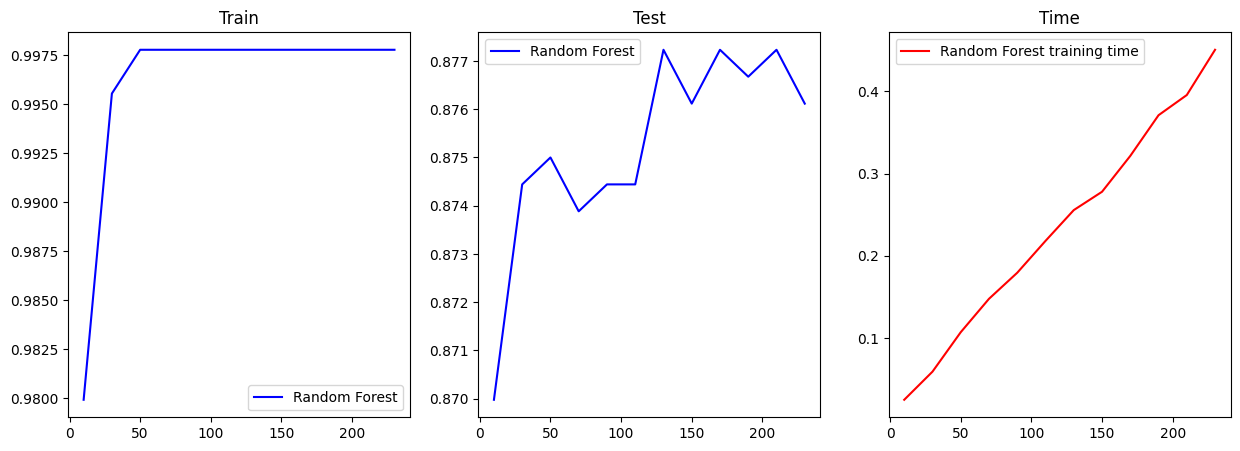

In [ ]:
acc_train, acc_test, time_list = get_model_scores(RandomForestClassifier)

params = {1: [acc_train, 'Random Forest', 'Train'],
          2: [acc_test, 'Random Forest', 'Test'],
          3: [time_list, "Random Forest training time", 'Time']}

def plot_graphs(params):
    figure(figsize=(15, 5))
    color = 'b'
    n_list = np.arange(10, 250, 20)
    for num in range(1, 4):
        plt.subplot(1, 3, num)
        if num == 3:
            color = 'r'
        plot(n_list, params[num][0], label=params[num][1], c=color)
        plt.legend()
        plt.title(params[num][2])

plot_graphs(params)

Отметим, что с качество случайного леса растет и на обучающей, и на тестовой выборке, но если на обучающей мы довольно быстро достигаем числа деревьев, после которого качество уже не растет, то на тестовых данных видим более интересную, "зубчатую" картинку. Время обучения с увеличением числа деревьев тоже ожидаемо увеличивается.

Теперь посмотрим, как меняется качество бустинга при увеличении числа деревьев.

Постройте аналогичные графики, но для градиентного бустинга.

100%|██████████| 12/12 [00:02<00:00,  5.02it/s]


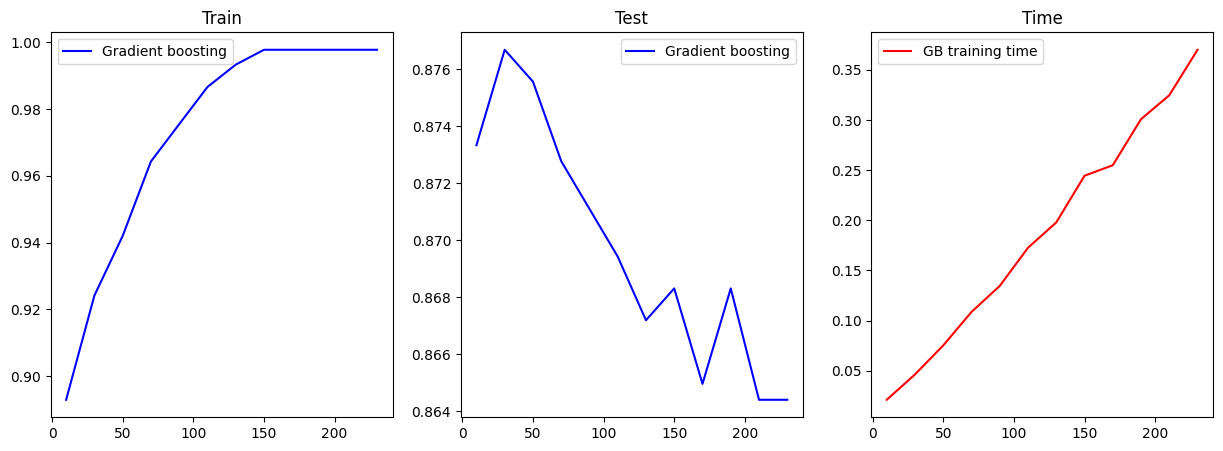

In [ ]:
acc_train, acc_test, time_list = get_model_scores(GradientBoostingClassifier)
params = {1: [acc_train, 'Gradient boosting', 'Train'],
          2: [acc_test, 'Gradient boosting', 'Test'],
          3: [time_list, "GB training time", 'Time']}

plot_graphs(params)

Видно, что у градиентный бустинг переобучился: его ошибка на обучающей выборке постоянно уменьшается, а ошибка на тестовых данных увеличивается, начиная с некоторого числа деревьев (так как на графике показано убывание точности (accuracy), равносильно сказать, что качество на тестовых данных падает). На train качество растет, на test падает - перед нами типичный случай переобучения.

Значит, надо остановиться на некотором числе деревьев, с наименьшей ошибкой на графике на тестовых данных.

Также, бороться с переобучением можно с помощью выбора очень простого базового алгоритма или
снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

$\eta$ - это наш learning_rate. Его уменьшение замедлит обучение по сравнению с бэггингом, но зато позволит побороть переобучение, хотя не до конца - оно останется при увеличении количества базовых алгоритмов для фиксированного $\eta$.

Давайте поменяем значение с 0.1 на 0.01 и обучим градиентный бустинг еще раз:

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.89it/s]


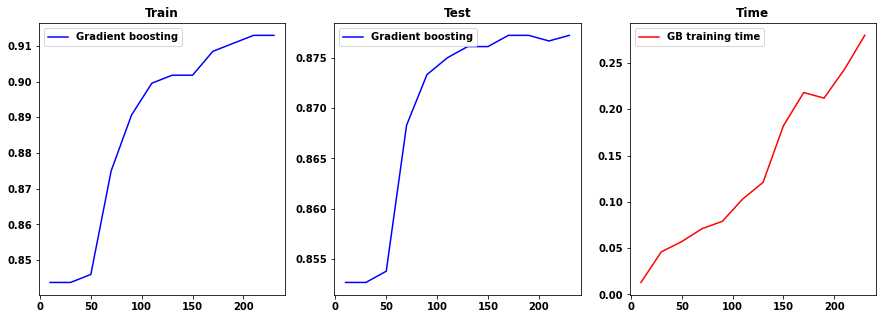

In [ ]:
acc_train, acc_test, time_list = get_model_scores(GradientBoostingClassifier, learning_rate=0.01)
params = {1: [acc_train, 'Gradient boosting', 'Train'],
          2: [acc_test, 'Gradient boosting', 'Test'],
          3: [time_list, "GB training time", 'Time']}

plot_graphs(params)

Давайте попробуем улучшить качество, вспомним, что можно подбирать наилучшие гиперпараметры у модели через `GridSearchCV`. Подберите `max_features`, `max_depth` и `min_samples_leaf` для градиентного бустинга с его помощью.

In [ ]:
from sklearn.model_selection import GridSearchCV

Дефолтные параметры c accuracy 0.87 у нас были такие:

In [ ]:
model = GradientBoostingClassifier(
    criterion='friedman_mse',
    n_estimators=10,
    random_state=42
)

model.max_features, model.max_depth, model.min_samples_leaf, model.n_estimators

(None, 3, 1, 10)

In [ ]:
%%time

parameters = {'max_features': [3, 5, 10, None],
              'max_depth': np.arange(1, 10, 2),
              'min_samples_leaf': np.arange(1, 20, 5)}

model = model = GradientBoostingClassifier(criterion='friedman_mse', n_estimators=10, random_state=42)
clf = GridSearchCV(model, parameters)
clf.fit(X, y)

print(f'Параметры лучшей модели по качеству на test: {clf.best_params_}')
print(f'Лучшая модель: {clf.best_estimator_}')
print(f'Лучшая Accuracy: {round(clf.best_score_, 2)}', end='\n\n')

Параметры лучшей модели по качеству на test: {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 16}
Лучшая модель: GradientBoostingClassifier(criterion='mse', max_depth=5, max_features=10,
                           min_samples_leaf=16, n_estimators=10,
                           random_state=42)
Лучшая Accuracy: 0.88

Wall time: 14.4 s


#### Take away:

Случайный лес и градиентный бустинг - это мощные ансамблевые алгоритмы, которые при должной настройке параметров показывают хорошее качество работы. Но надо помнить, что градиентный бустинг имеет склонность к переобучению с увеличением числа деревьев, и аккуратно подбирать число деревьев для алгоритма.

#### Дополнительные материалы для искушенных:

1. [Документация sklearn по GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
2. [Открытый курс машинного обучения. Тема 10. Градиентный бустинг](https://habr.com/ru/company/ods/blog/327250/)
3. [Пишем XGBoost с нуля. Часть 1](https://habr.com/ru/company/vk/blog/438560/)
4. [Пишем XGBoost с нуля. Часть 2](https://habr.com/ru/company/vk/blog/438562/)
5. [Gradient Boosting explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)